USE THIS COLLAB FOR RUNNING FMNIST AND MNIST DATASET. FOR DVS DATASET WE NEED TO UPLOAD A IBM DATA SET ".tar.gz" WHICH IS PUBLICALLY AVALIABLE AND FOR USING THIS WE NEED TI INSTALL TONIC. TO AVOID ISSUES WITH _items downgrade your pytorch version to 10.2. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install All Required Packages and Import Necessary Libraries

In [ ]:
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/jeshraghian/QSNNs/main/requirements.txt', 'requirements.txt')
!pip install -r requirements.txt --quiet
import torch, torch.nn as nn
import snntorch as snn
import brevitas.nn as qnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.7/104.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.4/411.4 kB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.4 MB/s eta 0:00:00


## Create a Dataloader for the FashionMNIST Dataset

Download and apply transforms to the FashionMNIST dataset.

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


data_path='/content/drive/MyDrive/DVS  Gesture dataset' # Directory where FMNIST dataset is stored
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Use GPU if available

# Define a transform to normalize data
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Download and load the training and test FashionMNIST datasets
fmnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)
fmnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:00<00:00, 115934575.49it/s]


Extracting /content/drive/MyDrive/DVS  Gesture dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/DVS  Gesture dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 6126336.54it/s]

Extracting /content/drive/MyDrive/DVS  Gesture dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/DVS  Gesture dataset/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 64895454.67it/s]


Extracting /content/drive/MyDrive/DVS  Gesture dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/DVS  Gesture dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 26789425.55it/s]


Extracting /content/drive/MyDrive/DVS  Gesture dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/DVS  Gesture dataset/FashionMNIST/raw



To speed-up simulations for demonstration purposes, the below code cell can be run to reduce the number of samples in the training and test sets by a factor of 10.

In [ ]:
from snntorch import utils


utils.data_subset(fmnist_train, 10)
utils.data_subset(fmnist_test, 10)

Dataset FashionMNIST
    Number of datapoints: 1000
    Root location: /content/drive/MyDrive/DVS  Gesture dataset
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=(0,), std=(1,))
           )

Create DataLoaders with batches of 128 samples and shuffle the training set.

In [ ]:
batch_size = 128 # Batches of 128 samples
trainloader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True)
testloader = DataLoader(fmnist_test, batch_size=batch_size, shuffle=False)

## Define Network Parameters

We have only specified 15 epochs without early stopping as a quick, early demonstration. Feel free to increase this. 

In [ ]:
config = {
    "num_epochs": 15,  # Number of epochs to train for (per trial)
    "batch_size": 128,  # Batch size
    "seed": 0,  # Random seed
    
    # Quantization
    "num_bits": 4,  # Bit resolution
    
    # Network parameters
    "grad_clip": False,  # Whether or not to clip gradients
    "weight_clip": False,  # Whether or not to clip weights
    "batch_norm": True,  # Whether or not to use batch normalization
    "dropout": 0.07,  # Dropout rate
    "beta": 0.97,  # Decay rate parameter (beta)
    "threshold": 2.5,  # Threshold parameter (theta)
    "lr": 3.0e-3,  # Initial learning rate
    "slope": 5.6,  # Slope value (k)
    
    # Fixed params
    "num_steps": 100,  # Number of timesteps to encode input for
    "correct_rate": 0.8,  # Correct rate
    "incorrect_rate": 0.2,  # Incorrect rate
    "betas": (0.9, 0.999),  # Adam optimizer beta values
    "t_0": 4690,  # Initial frequency of the cosine annealing scheduler
    "eta_min": 0,  # Minimum learning rate
}

## Define the Network Architecture
* 5 $\times$ Conv Layer w/16 Filters
* 2 $\times$ 2 Average Pooling
* 5 $\times$ Conv Layer w/64 Filters
* 2 $\times$ 2 Average Pooling
* (64 $\times$ 4 $\times$ 4) -- 10 Dense Layer

In [ ]:
from snntorch import surrogate
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_bits = config["num_bits"]
        self.thr = config["threshold"]
        self.slope = config["slope"]
        self.beta = config["beta"]
        self.num_steps = config["num_steps"]
        self.batch_norm = config["batch_norm"]
        self.p1 = config["dropout"]
        self.spike_grad = surrogate.fast_sigmoid(self.slope)
        
        # Initialize Layers
        self.conv1 = qnn.QuantConv2d(1, 16, 5, bias=False, weight_bit_width=self.num_bits)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.lif1 = snn.Leaky(self.beta, threshold=self.thr, spike_grad=self.spike_grad)
        self.conv2 = qnn.QuantConv2d(16, 64, 5, bias=False, weight_bit_width=self.num_bits)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.lif2 = snn.Leaky(self.beta, threshold=self.thr, spike_grad=self.spike_grad)
        self.fc1 = qnn.QuantLinear(64 * 4 * 4, 10, bias=False, weight_bit_width=self.num_bits)
        self.lif3 = snn.Leaky(self.beta, threshold=self.thr, spike_grad=self.spike_grad)
        self.dropout = nn.Dropout(self.p1)

    def forward(self, x):
        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        # Forward pass
        for step in range(self.num_steps):
            cur1 = F.avg_pool2d(self.conv1(x), 2)
            if self.batch_norm:
                cur1 = self.conv1_bn(cur1)

            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = F.avg_pool2d(self.conv2(spk1), 2)
            if self.batch_norm:
                cur2 = self.conv2_bn(cur2)

            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.dropout(self.fc1(spk2.flatten(1)))
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

net = Net(config).to(device)

## Define the Optimizer, Learning Rate Scheduler, and Loss Function
* Adam optimizer
* Cosine Annealing Scheduler
* MSE Spike Count Loss (Target spike count for correct and incorrect classes are specified)

In [ ]:
import snntorch.functional as SF#cosine scheduler


optimizer = torch.optim.Adam(net.parameters(), 
    lr=config["lr"], betas=config["betas"]
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
    T_max=config["t_0"], 
    eta_min=config["eta_min"], 
    last_epoch=-1
)
criterion = SF.mse_count_loss(correct_rate=config["correct_rate"], 
    incorrect_rate=config["incorrect_rate"]
)



In [ ]:
"""import snntorch.functional as SF #linear


optimizer = torch.optim.Adam(net.parameters(), 
    lr=config["lr"], betas=config["betas"]
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
    step_size=1000, 
    gamma=0.5
)
criterion = SF.mse_count_loss(correct_rate=config["correct_rate"], 
    incorrect_rate=config["incorrect_rate"]
)
"""

In [ ]:
"""import snntorch.functional as SF#multi step

optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"], betas=config["betas"])

# Define the schedule steps and corresponding learning rates
milestones = [10, 20, 30]
gamma = 0.1
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

criterion = SF.mse_count_loss(correct_rate=config["correct_rate"], incorrect_rate=config["incorrect_rate"])
"""

## Train and Evaluate the Network

As the learning rate follows a periodic schedule, the accuracy will oscillate across the training process, but with a general tendency to improve.

In [ ]:
def train(config, net, trainloader, criterion, optimizer, device="cpu", scheduler=None):
    """Complete one epoch of training."""
    
    net.train()
    loss_accum = []
    lr_accum = []
    i = 0
    for data, labels in trainloader:
        data, labels = data.to(device), labels.to(device)
        spk_rec, _ = net(data)
        loss = criterion(spk_rec, labels)
        optimizer.zero_grad()
        loss.backward()

        ## Enable gradient clipping
        if config["grad_clip"]:
            nn.utils.clip_grad_norm_(net.parameters(), 1.0)

        ## Enable weight clipping
        if config["weight_clip"]:
            with torch.no_grad():
                for param in net.parameters():
                    param.clamp_(-1, 1)

        optimizer.step()
        scheduler.step()
        loss_accum.append(loss.item() / config["num_steps"])
        lr_accum.append(optimizer.param_groups[0]["lr"])

    return loss_accum, lr_accum

def test(config, net, testloader, device="cpu"):
    """Calculate accuracy on full test set."""
    correct = 0
    total = 0
    with torch.no_grad():
        net.eval()
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs, _ = net(images)
            accuracy = SF.accuracy_rate(outputs, labels)
            total += labels.size(0)
            correct += accuracy * labels.size(0)

    return 100 * correct / total

loss_list = []
lr_list = []

print(f"=======Training Network=======")
# Train
for epoch in range(config['num_epochs']):
    loss, lr = train(config, net, trainloader, criterion, optimizer, 
        device, scheduler
    )
    loss_list = loss_list + loss
    lr_list = lr_list + lr
    # Test
    test_accuracy = test(config, net, testloader, device)
    print(f"Epoch: {epoch} \tTest Accuracy: {test_accuracy}")

=======Training Network=======
Epoch: 0 	Test Accuracy: 77.6
Epoch: 1 	Test Accuracy: 81.3
Epoch: 2 	Test Accuracy: 82.7
Epoch: 3 	Test Accuracy: 84.8
Epoch: 4 	Test Accuracy: 84.4
Epoch: 5 	Test Accuracy: 85.8
Epoch: 6 	Test Accuracy: 85.0
Epoch: 7 	Test Accuracy: 84.9
Epoch: 8 	Test Accuracy: 86.3
Epoch: 9 	Test Accuracy: 85.7
Epoch: 10 	Test Accuracy: 86.0
Epoch: 11 	Test Accuracy: 86.3
Epoch: 12 	Test Accuracy: 86.4
Epoch: 13 	Test Accuracy: 86.1
Epoch: 14 	Test Accuracy: 87.0


## Plot the Training Loss and Learning Rate Over Time

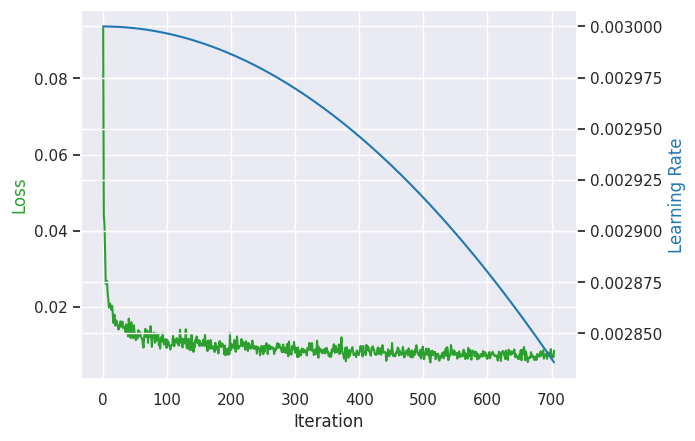

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(loss_list, color='tab:green')
ax2.plot(lr_list, color='tab:blue')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss', color='tab:green')
ax2.set_ylabel('Learning Rate', color='tab:blue')
plt.show()